In [1]:
import pyaudio
import audioop
import struct
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from sklearn.neighbors import KNeighborsClassifier

In [18]:
class TapDetector():
    def __init__(this,channels,rate,index,frames,chunk,tapSize):
        this.audio = pyaudio.PyAudio()
        this.fullFrames = np.full((tapSize,chunk),None,dtype='float64')
        this.frames = np.zeros(tapSize)
        this.all = []
        this.tapSize = tapSize
        this.currentFrame = 0
        this.chunk = chunk
        this.rate = rate
        this.cooldown =0
        this.trainingSets = []
        this.negativeTrainingSet = []
        this.clf = None
        this.classifier = KNeighborsClassifier(3)
        this.stream = this.audio.open(format = pyaudio.paInt16,
                                      channels = channels,
                                      rate = rate,
                                      input = True,
                                      input_device_index = index,
                                      frames_per_buffer = frames)
    
    def start(this,seconds):
        print("Recording Started")
        print(not this.clf == None)
        for i in range(0,int(this.rate / this.chunk * seconds)):
            if this.record():
                print("clf={}".format(this.clf))
                if not this.clf == None:
                    flat = np.array([np.array(x).flatten() for x in this.fullFrames]).flatten()
                    print(np.array(flat).shape)
                    prediction = this.clf.predict([flat])
                    print(prediction)
        print("Recording Finnished")
        plt.plot(this.all)
        plt.show()
    
    def record(this):
        tapFound = False
        data = this.stream.read(this.chunk, exception_on_overflow=False)
        decoded = np.fromstring(data.hex(), 'Float32').tolist()
        this.all.append(audioop.rms(data, 2))
        this.frames[this.currentFrame] = audioop.rms(data, 2)
        this.fullFrames[this.currentFrame] = decoded
        this.currentFrame = (this.currentFrame+1)%this.tapSize
        if(this.cooldown <= 0):
            tapFound = this.isTap(9000)
            return tapFound
        else:
            this.cooldown -= 1
        return tapFound
    
    def callibrate(this,buttons,tapsNeeded):
        for button in range(0,buttons):
            this.trainingSets.append([])
            print("Callibrating button position {}".format(button))
            for tap in range(1,tapsNeeded+1):
                while(not this.record()):
                    d = 1
                this.trainingSets[button].append(this.fullFrames)
                print("{}/{} taps registered for button {}".format(tap,tapsNeeded,button))
        for tap in range(1,tapsNeeded+1):
            print("Tap at a place with no button")
            while(not this.record()):
                d = 1
            this.negativeTrainingSet.append(this.fullFrames)
            print("{}/{} false taps registered so far".format(tap,tapsNeeded))
        this.buttonTraining()

    def buttonTraining(this):
        positiveTrainX = [np.array(x).flatten() for x in this.trainingSets[0]]
        positiveTrainY = np.full( len(positiveTrainX), 1)
        negativeTrainX = [np.array(x).flatten() for x in this.negativeTrainingSet]
        negativeTrainY = np.full( len(negativeTrainX), 0)
        trainX = positiveTrainX
        trainX.extend(negativeTrainX)
        trainY = np.hstack([positiveTrainY,negativeTrainY])
        #print(positiveTrainX[2],negativeTrainX[0])
        print(np.array(positiveTrainX).shape)
        print(np.array(trainX[0]).shape)
        print(np.array(trainY).shape)
        #print(trainX.shape,trainY.shape)
        this.clf = this.classifier.fit(trainX,trainY)
        
    def stop(this):
        this.stream.stop_stream()
        this.stream.close()
    
    def plot(this):
        plt.plot(np.hstack([this.frames[this.currentFrame:],this.frames[:this.currentFrame]]))
        #plt.show()
    
    def isTap(this,threshold):
        soundSlice = np.hstack([this.frames[this.currentFrame:],this.frames[:this.currentFrame]])
        diff = np.diff(soundSlice)
        maxPeaks = argrelextrema(soundSlice, np.greater)
        if len(maxPeaks) > 0:
            maxPeaks = maxPeaks[0].tolist()
        if len(maxPeaks) == 0:
            return False
        if soundSlice[maxPeaks[0]] > threshold and diff[maxPeaks[0]]**2 > 5000 and maxPeaks[0] > 1:
            for i in range(1,len(maxPeaks)):
                if soundSlice[maxPeaks[i]] > (soundSlice[maxPeaks[0]] * 0.5):
                    return False
            this.cooldown = 50
            print("found a tap")
            this.plot()
            return True
        return False
                   
    

Callibrating button position 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
1/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
2/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
3/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
4/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
5/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
6/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
7/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
8/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
9/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
10/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
11/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
12/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
13/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
14/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
15/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
16/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
17/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
18/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
19/20 taps registered for button 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
20/20 taps registered for button 0
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
1/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
2/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
3/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
4/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
5/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
6/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
7/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
8/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
9/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
10/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
11/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
12/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
13/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
14/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
15/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
16/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
17/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
18/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
19/20 false taps registered so far
Tap at a place with no button


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
20/20 false taps registered so far
(40, 25600)
(25600,)
(40,)
Recording Started
True


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
clf=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
(25600,)
[1]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
clf=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
(25600,)
[1]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
clf=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
(25600,)
[1]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


found a tap
clf=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
(25600,)
[1]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Recording Finnished


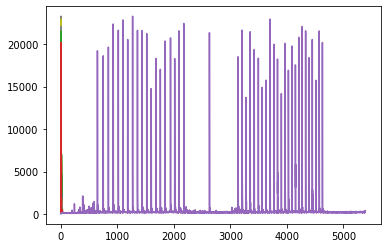

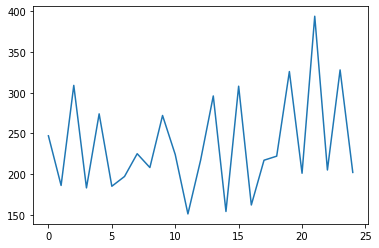

In [21]:
channels =1
rate = 100000#44100
index = 0
frames = 5
chunk = 1024
tapSize = 25
detector = TapDetector(channels,rate,index,frames,chunk,tapSize)
detector.callibrate(1,20)
detector.start(10)
detector.plot()
detector.stop()

In [ ]:
        
    def findPeaks(this,soundSlice,threshold):
        diff = np.diff(soundSlice)
        startPeak,startId = 0,0
        lowPeak,lowId = 0,0
        afterPeak, afterId = 0,0
        index = 0
        for db in soundSLice:
            index += 1
            if(lowId = 0 and db > 0 and db > startPeak and db >= threshold):
                startPeak = db
                startId = index
            elif(afterId = 0 and db < 0 and db < lowPeak):
                lowPeak = db,
                lowId = index
            elif(index > lowId and db > 0 and db > afterPeak):
                afterPeak = db
                afterId = index
            elif(after)